In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image

In [189]:
# grid and parameters
nx, ny = 512, 512 # grid size
Lx, Ly = 4.0, 4.0 # physical size
dx, dy = Lx / nx, Ly / ny # grid spacing
x = np.linspace(-Lx / 2, Lx / 2, nx)
y = np.linspace(-Ly / 2, Ly / 2, ny)
X, Y = np.meshgrid(x, y)

In [190]:
# cylinder parameters
radius = 0.1
U_inf = 40.0 # free stream velocity

# velocity field (left to right)
u = np.ones((ny, nx)) * U_inf # x-velocity
v = np.zeros((ny, nx)) # y-velocity

# flow_angle = np.radians(30)
# u = np.ones((ny, nx)) * U_inf * np.cos(angle)  # x-velocity
# v = np.ones((ny, nx)) * U_inf * np.sin(angle)  # y-velocity

# mask for the cylinder
mask = (X**2 + Y**2) < radius**2

In [191]:
# load and process the rocket image to create a mask
image_path = 'img/rocket-model.png'
image = Image.open(image_path).convert('L') # convert to grayscale
image_array = np.array(image)
threshold = 128
rocket_mask = image_array > threshold

# target size for the rocket mask (smaller than the grid size)
target_size = (int(nx / 4), int(ny / 4))

# resize the mask
rocket_mask_full_size = Image.fromarray(rocket_mask).resize(target_size, Image.NEAREST)
rocket_mask_full_size = np.array(rocket_mask_full_size)

# create a larger mask and place the resized rocket mask in the center
rocket_mask_resized = np.zeros((ny, nx), dtype=bool)
y_offset = (ny - target_size[1]) // 2
x_offset = (nx - target_size[0]) // 2
rocket_mask_resized[y_offset:y_offset + target_size[1], x_offset:x_offset + target_size[0]] = rocket_mask_full_size

mask = rocket_mask_resized

In [192]:
# time stepping parameters
dt = 0.00001 # time step size for higher temporal resolution
nt = 1000 # number of time steps
nu = 0.000015 # kinematic viscosity

In [193]:
# apply boundary conditions
def apply_boundary_conditions(u, v):
    u[mask] = 0
    v[mask] = 0
    return u, v

In [194]:
# time stepping
for _ in range(nt):
    # compute derivatives
    u_x = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / (2 * dx)
    u_y = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / (2 * dy)
    v_x = (np.roll(v, -1, axis=1) - np.roll(v, 1, axis=1)) / (2 * dx)
    v_y = (np.roll(v, -1, axis=0) - np.roll(v, 1, axis=0)) / (2 * dy)
    
    # laplacian
    laplacian_u = (np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) + 
                   np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) - 4 * u) / (dx * dy)
    laplacian_v = (np.roll(v, 1, axis=1) + np.roll(v, -1, axis=1) + 
                   np.roll(v, 1, axis=0) + np.roll(v, -1, axis=0) - 4 * v) / (dx * dy)
    
    # update velocity field
    u_new = u + dt * (-u * u_x - v * u_y + nu * laplacian_u)
    v_new = v + dt * (-u * v_x - v * v_y + nu * laplacian_v)
    
    # boundary conditions
    u, v = apply_boundary_conditions(u_new, v_new)

In [195]:
# gaussian filter for smoothing
u_smoothed = gaussian_filter(u, sigma=1)

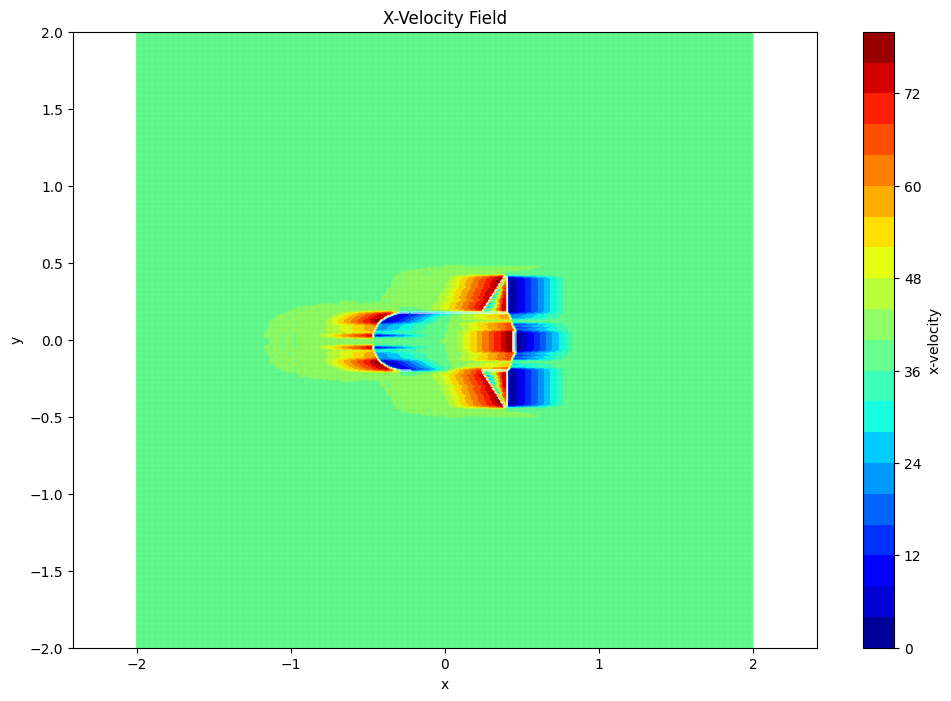

In [196]:
# plot x-velocity field
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, u_smoothed, 20, cmap='jet')
plt.colorbar(label='x-velocity')

# draw the cylinder
# circle = plt.Circle((0, 0), radius, color='white', alpha=1.0)
# plt.gca().add_artist(circle)
plt.contour(X, Y, rocket_mask_resized, colors='white', linewidths=0.5)

# Draw the rocket
rocket_mask_display = np.ma.masked_where(~rocket_mask_resized, rocket_mask_resized)
plt.imshow(rocket_mask_display, extent=[-Lx/2, Lx/2, -Ly/2, Ly/2], cmap='gray', alpha=0.5)

# Plot the grid points
plt.scatter(X, Y, color='black', s=0.00005)  # Adjust 's' for point size if needed

plt.title('X-Velocity Field')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [197]:
# parameters
rho = 1.0 # density of the fluid (assumed constant)
P_inf = 1.0 # reference pressure (free-stream pressure)

In [198]:
# calculate pressure field
P = P_inf + 0.5 * rho * (U_inf**2 - u**2 - v**2)

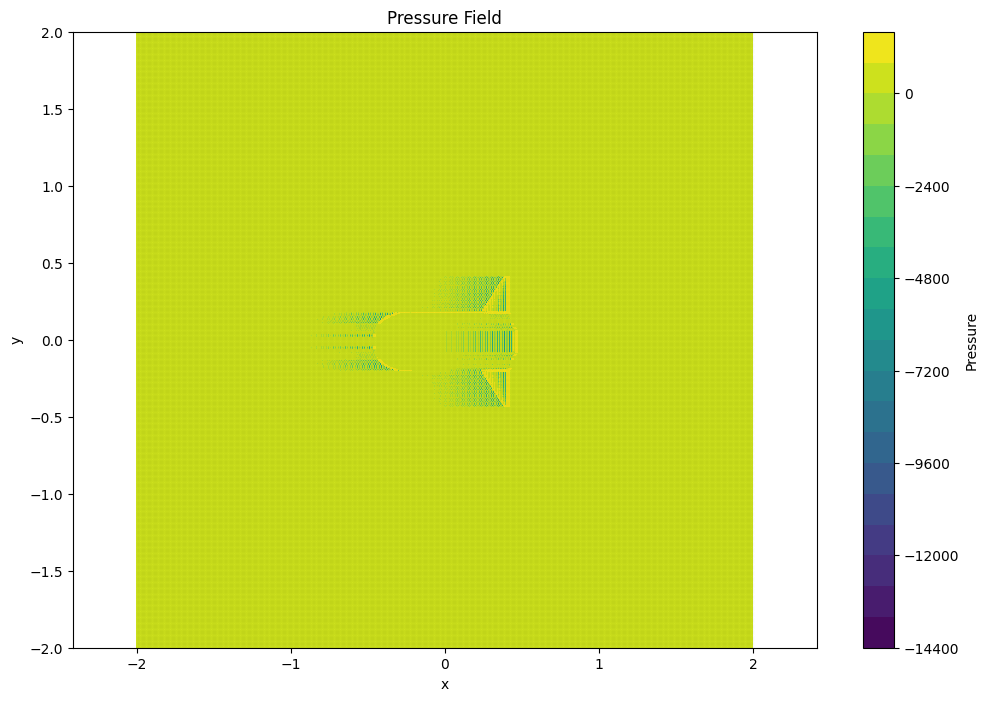

In [199]:
# olot the pressure field
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, P, 20, cmap='viridis')
plt.colorbar(label='Pressure')

# draw the rocket
rocket_mask_display = np.ma.masked_where(~rocket_mask_resized, rocket_mask_resized)
plt.imshow(rocket_mask_display, extent=[-Lx/2, Lx/2, -Ly/2, Ly/2], cmap='gray', alpha=0.5)

# plot the grid points
plt.scatter(X, Y, color='black', s=0.00005)  # Adjust 's' for point size if needed

plt.title('Pressure Field')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()